# SETI Energy Detection 

In [1]:
!pip install blimpy
!wget http://blpd13.ssl.berkeley.edu/dl/GBT_58402_65614_HIP65946_time.h5

     |████████████████████████████████| 276kB 3.5MB/s 
     |████████████████████████████████| 5.4MB 9.2MB/s 


In [0]:
%matplotlib inline
import numpy as np
from scipy import stats, interpolate
from blimpy import Waterfall
from matplotlib import pyplot as plt
from bisect import bisect_left
from tqdm import tqdm
import dask.array as da
import h5py as h5
import os
import pandas as pd
import pylab as plt
%matplotlib inline
from copy import deepcopy

In [47]:
obs = Waterfall("/content/GBT_58402_65614_HIP65946_time.h5", load_data=False)
obs.info()
obs = Waterfall("/content/GBT_58402_65614_HIP65946_time.h5", max_load=5, t_start=0, t_stop=16000)
data = obs.data
channel_len  = np.int(np.round(187.5/64/abs(obs.header['foff'])))

blimpy.io.base_reader INFO     Skipping loading data ...

--- File Info ---
DIMENSION_LABELS : [b'frequency' b'feed_id' b'time']
        az_start :                              0.0
       data_type :                                1
            fch1 :                2720.80078125 MHz
            foff :                -0.3662109375 MHz
           ibeam :                                0
      machine_id :                               10
          nbeams :                                0
           nbits :                                8
          nchans :                             2464
            nifs :                                1
     rawdatafile :                                 
     source_name :                         HIP65946
         src_dej :                     53:18:37.301
         src_raj :                     13:31:10.873
    telescope_id :                                6
           tsamp :            0.0003495253333333333
   tstart (ISOT) :          2018-10-11T

8

Fitting Spline


Text(0, 0.5, 'Power')

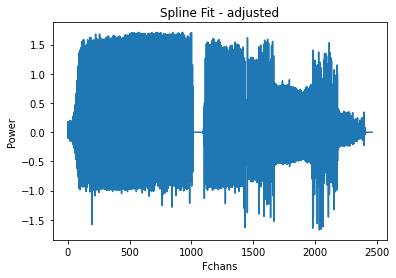

In [48]:
%matplotlib inline
average_power = np.zeros((data.shape[2]))
shifted_power = np.zeros((int(data.shape[2]/8)))
x=[]
spl_order = 2
print("Fitting Spline")
data_adjust = np.zeros(data.shape)
average_power = data.mean(axis=0)
coarse_channel_width = channel_len
for i in range(0, data.shape[2],coarse_channel_width):
    average_channel = average_power[0,i:i+coarse_channel_width]
    x = np.arange(0,coarse_channel_width,1)
    knots = np.arange(0, coarse_channel_width, coarse_channel_width//spl_order+1)
    tck = interpolate.splrep(x, average_channel, s=knots[1:])
    xnew = np.arange(0, coarse_channel_width,1)
    ynew = interpolate.splev(xnew, tck, der=0)
    data_adjust[:,0,i:i+coarse_channel_width]  = data[:,0,i:i+coarse_channel_width] - ynew

plt.figure()
plt.plot( data_adjust.mean(axis=0)[0,:])
plt.title('Spline Fit - adjusted')
plt.xlabel("Fchans")
plt.ylabel("Power")

In [0]:
def norm_test(arr):
    return stats.normaltest(arr.flatten())
def top(arr, top = 10):
  newarr=deepcopy(arr)
  candidate = []
  # Delete the first and second element fourier transform
  newarr[0]=0
  newarr[1]=0
  for i in range(top):
    # We add 1 as the 0th index = period of 1 not 0
    index = np.argmax(newarr)
    candidate.append(index)
    newarr[index]=0
  return candidate

In [50]:
res = []
slice_length = 1
num_chan = int(data.shape[2]/channel_len)
data_temp=data_adjust[:,0,:]
for chan in tqdm(range(num_chan)):
  res.append([])
  window = data_temp[:, channel_len*(chan):channel_len*(chan+1)]
  for i in range(0, channel_len-slice_length, 1):
    test_data = window[:, i:i+slice_length]
    s, p = norm_test(test_data)
    if p < 1e-25:
      res[chan].append((i, s, p))
    else:
      res[chan].append((i, 0, p))
print(len(res))
chan_hits = res
print(len(res))

100%|██████████| 308/308 [00:04<00:00, 71.27it/s]

308
308


In [0]:
result = np.zeros(((len(res))*(len(res[1])), 3))

for i in range(len(res)):
  for k in range(len(res[0])):
    result[i*(channel_len- slice_length)+k,0]=i*(channel_len- slice_length)+k
    result[i*(channel_len- slice_length)+k,1]=res[i][k][1]
    result[i*(channel_len- slice_length)+k,2]=res[i][k][2]


Fchan_index: 1949 S_VAL: 212777.01790190872
Fchan_index: 2006 S_VAL: 176000.88395935815
Fchan_index: 1948 S_VAL: 134340.3200944047


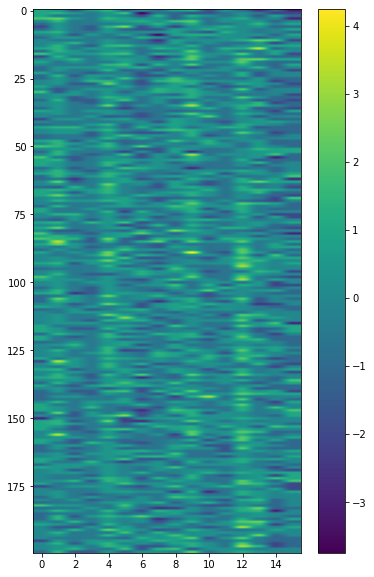

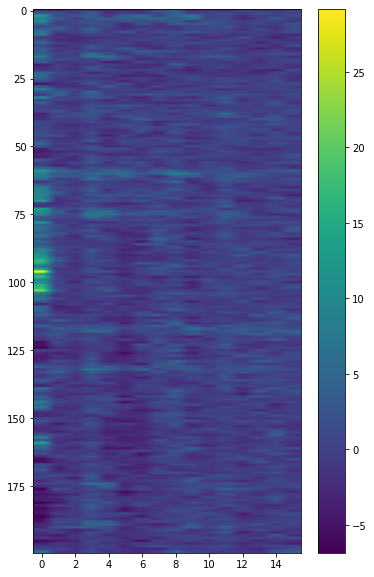

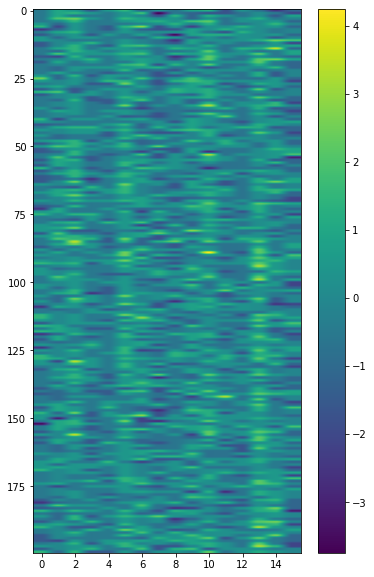

In [57]:
# slice just the stdv of the signals
s_val = result[:,1]
candidates = []
candidates = top(s_val, top=3)

for i in range(len(candidates)):
  max_index = candidates[i]
  print("Fchan_index: "+str(max_index)+" S_VAL: "+str(result[max_index,1]))
  f_low = max_index - channel_len
  f_high = max_index + channel_len
  fig = plt.figure(figsize=(6, 10))
  plt.imshow(data_adjust[:200,0,f_low:f_high], aspect='auto')
  plt.colorbar()